# **Imports**

Below are the imports used in the Notebook.

In [2]:
! pip install plotly

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 50.2 MB/s eta 0:00:0031m52.4 MB/s eta 0:00:01


In [1]:
# Common
import os
import keras 
import numpy as np
import tensorflow as tf

# Data
from keras.preprocessing.image import ImageDataGenerator as IDG

# Data Viz
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Pre-Trained Models
from tensorflow.keras.applications import InceptionV3, Xception, ResNet152V2, ResNet50V2, ResNet50

# Model
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Layer, ReLU, Add, InputLayer, Multiply

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model viz
from tensorflow.keras.utils import plot_model

2024-05-13 12:22:41.974280: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 12:22:42.017000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 12:22:42.756634: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# **Data -  Info**

Let's have a look at **Data Distribution**.

In [51]:
root_path = 'carla_trafficdata 1/train'

class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

print(class_names)

print(f"Total No. of Classes : {n_classes}")

['clear', 'rain', 'wet']
Total No. of Classes : 3


In [52]:
class_dis = [len(os.listdir(root_path + "/" + name)) for name in class_names]
class_dis

[1980, 1371, 1100]

It will be better to look at this through **Visualization**.

In [4]:
# ! pip install nbformat

In [5]:
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.5}})
fig.show()

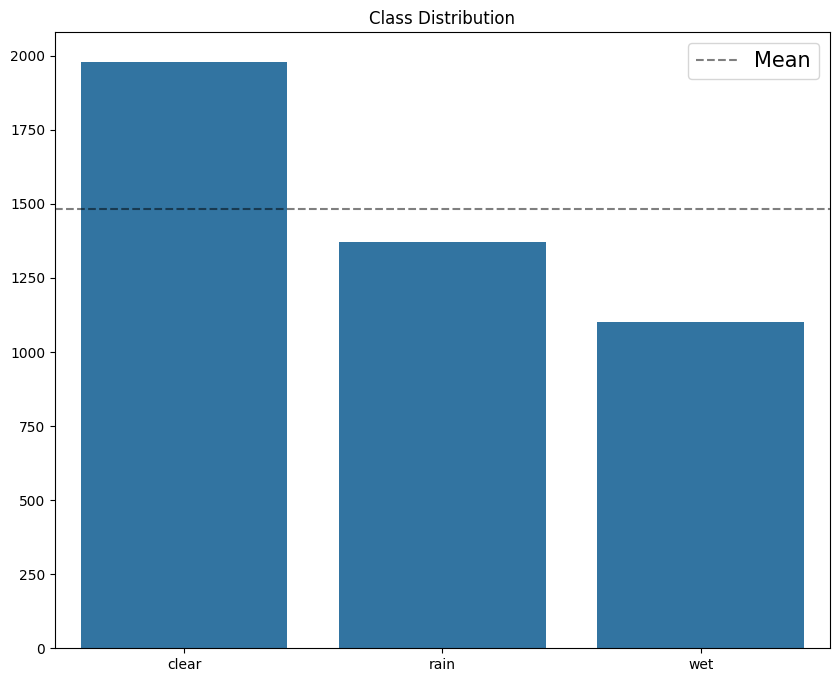

In [53]:
plt.figure(figsize=(10,8))
sns.barplot(
    x=class_names, 
    y=class_dis
)
plt.axhline(np.mean(class_dis), alpha=0.5, linestyle='--', color='k', label="Mean")
plt.title("Class Distribution")
plt.legend(fontsize=15)
plt.show()

This is **not a good news**. The classes are **not equally distributed**. This also means that our model can be **biased towards the highly occurring class**.

# **Data - Loading**

In [54]:
# Initialize DataGenerator
train_gen = IDG(rescale=1./255, horizontal_flip=True, rotation_range=20, validation_split=0.2)

# Load Data
train_ds = train_gen.flow_from_directory(root_path, target_size=(256,256), class_mode="binary", subset='training', shuffle=True, batch_size=32)
valid_ds = train_gen.flow_from_directory(root_path, target_size=(256,256), class_mode="binary", subset='validation', shuffle=True, batch_size=32)

Found 3561 images belonging to 3 classes.
Found 890 images belonging to 3 classes.


# **Data Visualization**

The best way to understand the data is to have a look at the data.

20
11
11
1
30
5
21
22
11
25
29
13
4
28
8
9
23
6
19
7


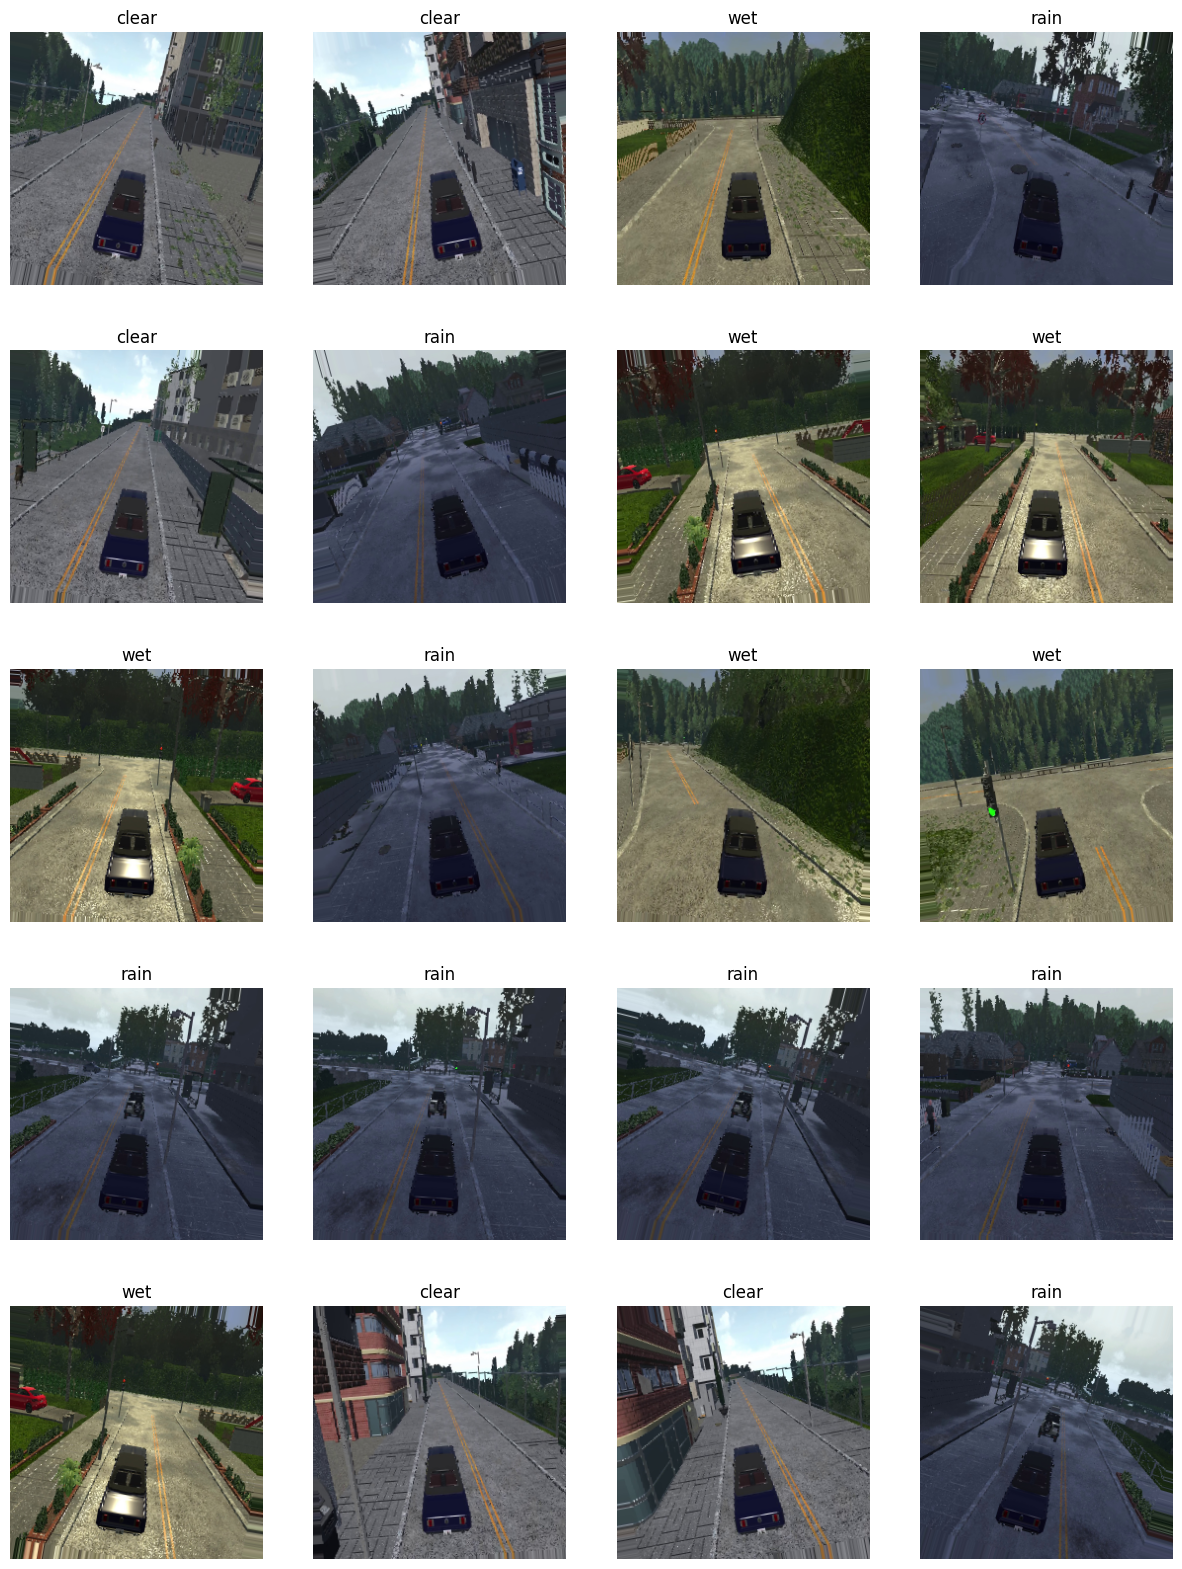

In [57]:
i=1
plt.figure(figsize=(15,20))
for images, labels in train_ds:
    id = np.random.randint(len(images))
    print(id)
    image, label = images[id], int(labels[id])

    plt.subplot(5, 4, i)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis('off')

    i+=1
    if i>=21: break

plt.show()

This will be a task because **both the geometry** and the **color matters** in deciding the **weather**.

# **ResNet152V2**

I tried **out various models** such as **inception**, **Xception** and other versions of **ResNet**, but **ResNet 150V2** seems to **perform the best**. The performance is **very close** to what **Xception** reached. The **training accuracy Resnet 150V2** reached is **91%** and **validation accuracy is 87%**, whereas **Xception** reach  **90% to 86%** accuracy, respectively.

---
I have also tried out **different compositions** for these particular **pre trained models**.

In [68]:
name = 'resnet_13/05'
# TL Model
base_model = ResNet152V2(include_top=False, input_shape=(256,256,3))
base_model.trainable = False

# Model
model = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation="softmax")
])

# Compile
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

In [69]:
model.fit(train_ds, epochs=500, callbacks=cbs, validation_data=valid_ds)

Epoch 1/500
112/112 [==============================] - 111s 931ms/step - loss: 0.0713 - accuracy: 0.9725 - val_loss: 1.4981e-04 - val_accuracy: 1.0000
Epoch 2/500
112/112 [==============================] - 102s 906ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 5.4572e-04 - val_accuracy: 1.0000
Epoch 3/500
112/112 [==============================] - 101s 898ms/step - loss: 5.4706e-04 - accuracy: 0.9997 - val_loss: 2.1947e-05 - val_accuracy: 1.0000
Epoch 4/500
112/112 [==============================] - 108s 963ms/step - loss: 3.2012e-04 - accuracy: 1.0000 - val_loss: 9.5946e-06 - val_accuracy: 1.0000
Epoch 5/500
112/112 [==============================] - 99s 887ms/step - loss: 1.6760e-04 - accuracy: 1.0000 - val_loss: 1.0497e-05 - val_accuracy: 1.0000
Epoch 6/500
112/112 [==============================] - 99s 881ms/step - loss: 1.5203e-04 - accuracy: 1.0000 - val_loss: 2.0858e-04 - val_accuracy: 1.0000
Epoch 7/500
112/112 [==============================] - 101s 898ms/step - loss: 7

# **Evaluation**

Let's evaluate the **model's performance**.

In [79]:
model = load_model('/home/user/weather_classification/resnet.h5')

1/1 [==============================] - 0s 35ms/step


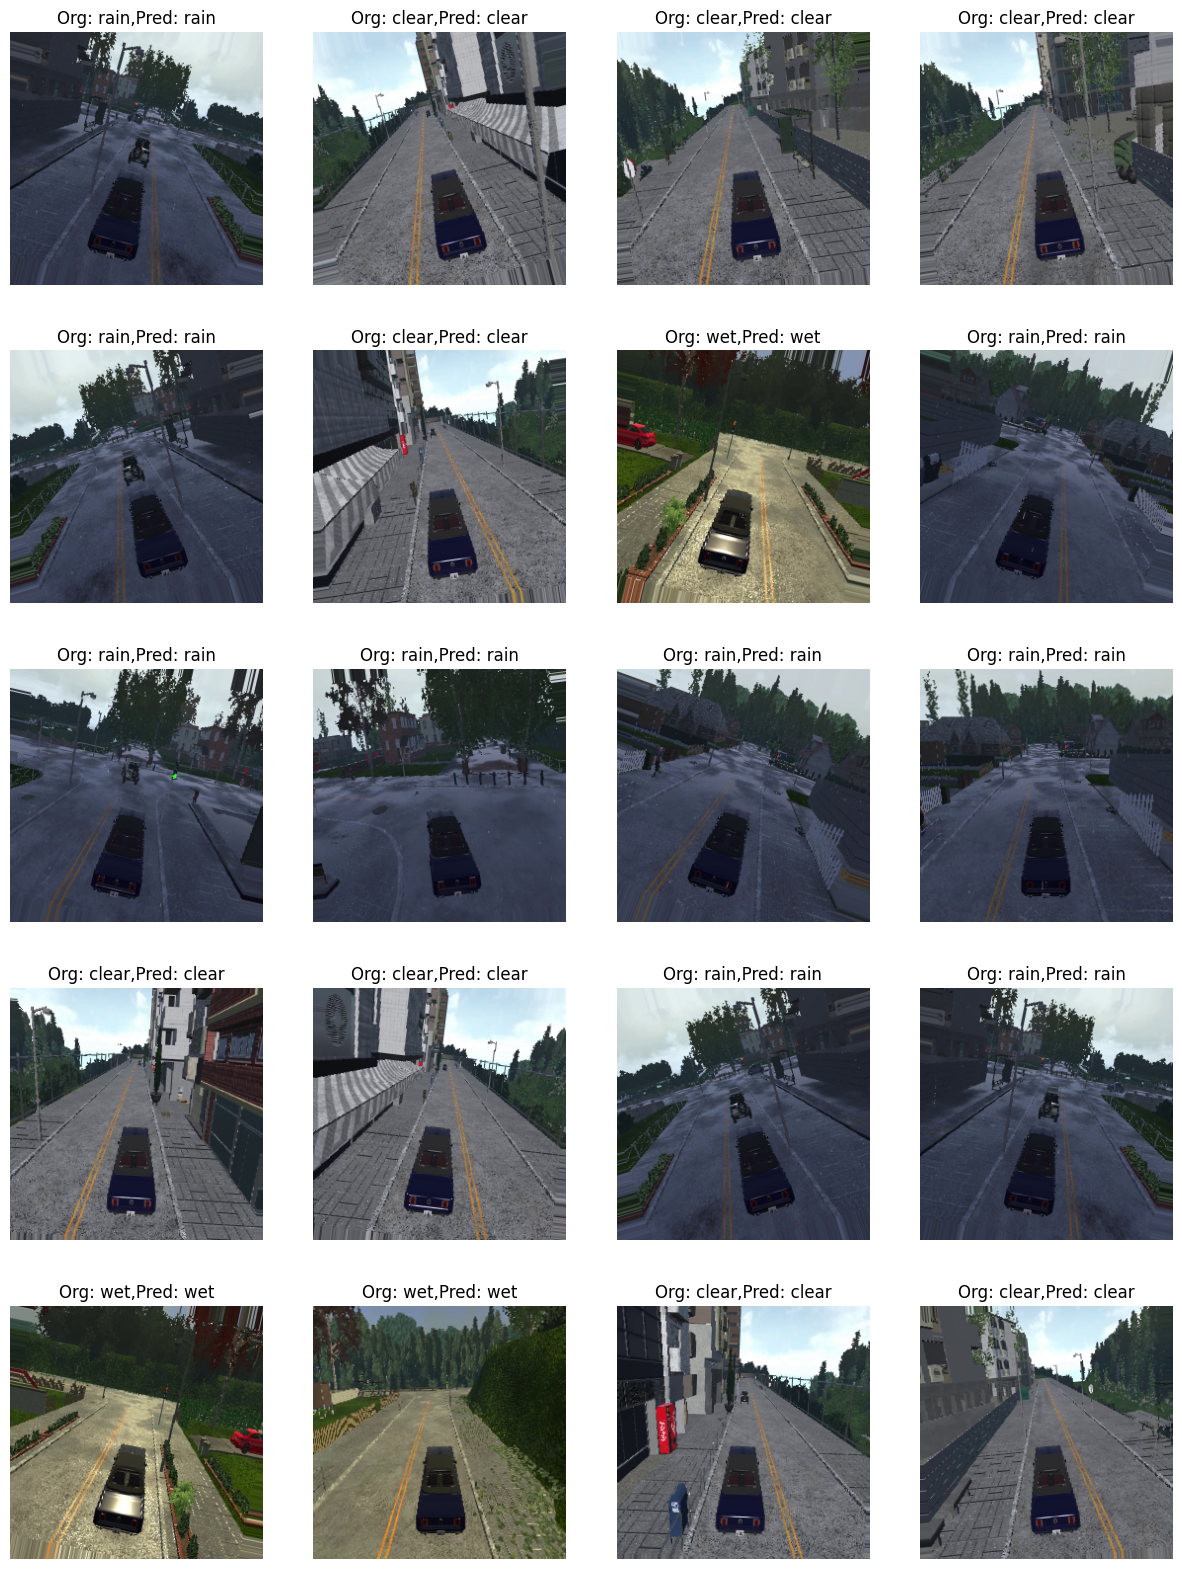

In [80]:
i=1
plt.figure(figsize=(15,20))
for images, labels in train_ds:
    id = np.random.randint(len(images))
    image, label = images[id], int(labels[id])
    pred_label = class_names[np.argmax(model.predict(image[np.newaxis,...]))]

    plt.subplot(5, 4, i)
    plt.imshow(image)
    plt.title(f"Org: {class_names[label]},Pred: {pred_label}")
    plt.axis('off')

    i+=1
    if i>=21: break

plt.show()

**Almost all the predictions are correct**. This shows that the model is **working perfectly**.

In [81]:
model.evaluate(valid_ds)

28/28 [==============================] - 23s 723ms/step - loss: 3.8044e-06 - accuracy: 1.0000


[3.804364041570807e-06, 1.0]

In [87]:
img = tf.keras.preprocessing.image.load_img('carla_trafficdata 1/val/rain/frame_000112.jpg', target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array]) 
predictions = model.predict(img_array)
print("prediction", predictions)

1/1 [==============================] - 0s 32ms/step
prediction [[1. 0. 0.]]


In [88]:
class_id = np.argmax(predictions, axis = 1)
print(class_id)

[0]
